(haldane-nb)=
# Haldane model

The Haldane model is a two-dimensional tight-binding model that exhibits topological properties. It is defined on a honeycomb lattice and includes complex next-nearest neighbor hopping terms. The model is characterized by a non-zero Chern number, which gives rise to the quantum Hall effect.

Here we will visualize the band structure and density of states of the Haldane model using the `pythtb` library.

In [1]:
from pythtb.tb_model import TBModel  
import numpy as np
import matplotlib.pyplot as plt

We start by defining the lattice vectors and orbital positions for the Haldane model. The orbital positions are given in reduced coordinates, this means if we specify an orbital vector by the list `[1/3, 1/3]`, the corresponding real-space position is obtained by multiplying the reduced coordinates by the lattice vectors:

$$
\mathbf{\tau} = \frac{1}{3} \mathbf{a}_{1} + \frac{1}{3} \mathbf{a}_{2}
$$

where $\mathbf{a}_{i}$ are the lattice vectors.

In [2]:
# define lattice vectors
lat = [[1, 0], [1/2, np.sqrt(3)/2]]
# define coordinates of orbitals
orb = [[1/3, 1/3], [2/3, 2/3]]

Next, we specify the real-space and reciprocal-space dimensions. In this case, we have a two-dimensional lattice, and periodic boundary conditions along each direction, so we set both `dim_r` and `dim_k` to 2.

Now we can pass all of this information to the `TBModel` class to initialize our tight-binding model with the specified geometry.

In [3]:
my_model = TBModel(dim_k=2, dim_r=2, lat=lat, orb=orb)

Next, we need to specify the hopping parameters for the model. In the Haldane model, we have two types of hopping: intra-sublattice hopping (between orbitals on the same sublattice) and inter-sublattice hopping (between orbitals on different sublattices). We can define these hopping parameters as follows:

:::{warning}
Once specifying the hopping from site $i$ to site $j + \mathbf{R}_{j}$ using the `TBModel.set_hop` method, it automatically specifies the hopping from site $j$ to site $i - \mathbf{R}$ as well. 
:::

In [4]:
delta = 0.2
t = -1.0
t2 = 0.15 * np.exp((1.0j) * np.pi / 2.0)
t2c = t2.conjugate()

# set on-site energies
my_model.set_onsite([-delta, delta])
# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])
my_model.set_hop(t, 0, 1, [0, 0])
my_model.set_hop(t, 1, 0, [1, 0])
my_model.set_hop(t, 1, 0, [0, 1])
# add second neighbour complex hoppings
my_model.set_hop(t2, 0, 0, [1, 0])
my_model.set_hop(t2, 1, 1, [1, -1])
my_model.set_hop(t2, 1, 1, [0, 1])
my_model.set_hop(t2c, 1, 1, [1, 0])
my_model.set_hop(t2c, 0, 0, [1, -1])
my_model.set_hop(t2c, 0, 0, [0, 1])

We generate a list of k-points following a segmented path in the BZ. The list of nodes (high-symmetry points) that will be connected is defined by the `path` variable. We then call the `k_path` function to construct the actual path. This takes the `path` variable and the total number of points to interpolate between the the nodes. This gives back the `k_vec`, `k_dist`, and `k_node` variables, which contain the interpolated k-points, their positions on the horizontal axis, and the positions of the original nodes, respectively.

In [5]:
path = [
    [0, 0],
    [2 / 3, 1 / 3],
    [1 / 2, 1 / 2],
    [1 / 3, 2 / 3],
    [0, 0],
]
# labels of the nodes
label = (r"$\Gamma $", r"$K$", r"$M$", r"$K^\prime$", r"$\Gamma $")

# call function k_path to construct the actual path
(k_vec, k_dist, k_node) = my_model.k_path(path, 101)

----- k_path report -----
Real-space lattice vectors:
 [[1.      0.     ]
 [0.5     0.86603]]
K-space metric tensor:
 [[ 1.33333 -0.66667]
 [-0.66667  1.33333]]
Nodes (reduced coords):
 [[0.      0.     ]
 [0.66667 0.33333]
 [0.5     0.5    ]
 [0.33333 0.66667]
 [0.      0.     ]]
Reciprocal-space vectors:
 [[ 1.      -0.57735]
 [ 0.       1.1547 ]]
Nodes (Cartesian coords):
 [[0.00000e+00 0.00000e+00]
 [6.66667e-01 1.56412e-17]
 [5.00000e-01 2.88675e-01]
 [3.33333e-01 5.77350e-01]
 [0.00000e+00 0.00000e+00]]
Segments:
  Node 0 [0. 0.] to Node 1 [0.66667 0.33333]: distance = 0.66667
  Node 1 [0.66667 0.33333] to Node 2 [0.5 0.5]: distance = 0.33333
  Node 2 [0.5 0.5] to Node 3 [0.33333 0.66667]: distance = 0.33333
  Node 3 [0.33333 0.66667] to Node 4 [0. 0.]: distance = 0.66667
Node distances (cumulative): [0.      0.66667 1.      1.33333 2.     ]
Node indices in path: [  0  33  50  67 100]
-------------------------


Diagonalizing the tight-binding Hamiltonian on this list of k-points is straightforward. The eigenvalues obtained from the diagonalization are then plotted as a function of the k-point positions to give us the band structure of the model

In [6]:
evals = my_model.solve_ham(k_vec)

As our final task, we will compute the density of states (DOS) from the obtained eigenvalues. To do so, we first need a grid of k-points spanning the full Brillouin zone. We can use the `Mesh` class from `pythtb` to create this grid.

In [12]:
from pythtb import Mesh

mesh = Mesh(my_model)
# create a 50x50 grid of k-points 
mesh.build_grid(shape_k=(50, 50), full_grid=True, exclude_k_endpoints=True)
# get the flattened list of k-points
kpts = mesh.flat

Lastly, we will diagonalize the Hamiltonian at each k-point to obtain the energies.

In [13]:
energies = my_model.solve_ham(kpts)
energies = energies.flatten()

Finally, we can visualize the band structure and density of states using the obtained eigenvalues.

Text(0, 0.5, 'Number of states')

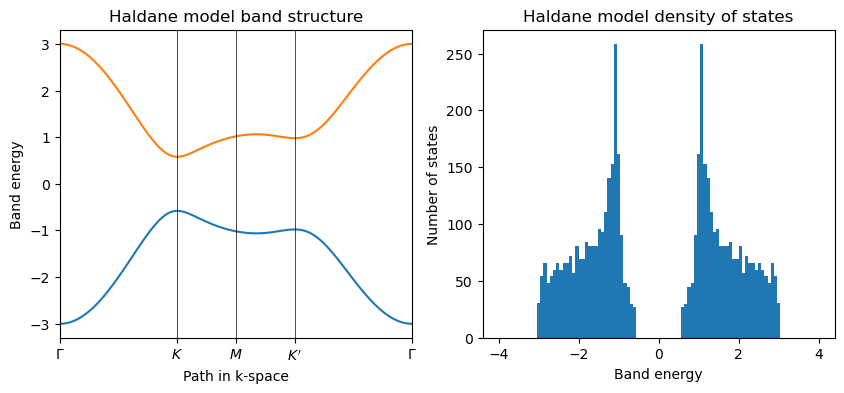

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(k_dist, evals)
ax[0].set_xlim(k_node[0], k_node[-1])
# put tickmarks and labels at node positions
ax[0].set_xticks(k_node)
ax[0].set_xticklabels(label)
# add vertical lines at node positions
for n in range(len(k_node)):
    ax[0].axvline(x=k_node[n], linewidth=0.5, color="k")
# put title
ax[0].set_title("Haldane model band structure")
ax[0].set_xlabel("Path in k-space")
ax[0].set_ylabel("Band energy")

# now plot density of states
ax[1].hist(energies, 100, range=(-4.0, 4.0))
# ax[1].set_ylim(0.0, 80.0)
ax[1].set_title("Haldane model density of states")
ax[1].set_xlabel("Band energy")
ax[1].set_ylabel("Number of states")